In [29]:
from datasets import load_dataset, DatasetDict

dataset = load_dataset("csv", data_files="archive/data.csv")["train"]

# Select the first 2000 rows
subset = dataset.select(range(1000))

# Convert the subset into a DatasetDict
subset_dict = DatasetDict({"train": subset})

dataset = subset_dict

In [30]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Sentence', 'Sentiment'],
        num_rows: 1000
    })
})

In [31]:
df = dataset["train"].to_pandas()
df["Sentiment"].unique()

array(['positive', 'negative', 'neutral'], dtype=object)

In [32]:
df

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
...,...,...
995,Finnish waste management and cleaning group La...,negative
996,The operating margin of Aker Yards Cruise & Fe...,neutral
997,HELSINKI Thomson Financial - Shares in Cargote...,negative
998,The program 's target is structural cost reduc...,positive


In [33]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

labels = encoder.fit_transform(dataset["train"]["Sentiment"])

In [34]:
dataset["train"] = dataset["train"].add_column("label", labels)
dataset['train'] = dataset['train'].remove_columns("Sentiment")
dataset = dataset.rename_column("Sentence", "text")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
})

In [35]:
dataset = dataset["train"].train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 800
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
})

In [36]:
checkpoint = "google-bert/bert-base-uncased"

In [37]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [38]:
def tokenize(sample):
    return tokenizer(sample["text"], truncation=True)

In [39]:
tokenized_dataset = dataset.map(tokenize, batched=True)

Map: 100%|██████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3508.85 examples/s]


In [40]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=8,  # batch size for training
    per_device_eval_batch_size=8,  # batch size for evaluation
    metric_for_best_model="f1",
    num_train_epochs=1,
    # report_to="none",
)

In [41]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [43]:
import evaluate
import numpy as np

metric = evaluate.load("f1")

In [44]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="weighted")

In [45]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

In [46]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,0.733721,0.613008


TrainOutput(global_step=100, training_loss=0.8361398315429688, metrics={'train_runtime': 490.7, 'train_samples_per_second': 1.63, 'train_steps_per_second': 0.204, 'total_flos': 20831182619184.0, 'train_loss': 0.8361398315429688, 'epoch': 1.0})

In [47]:
trainer.evaluate()

{'eval_loss': 0.733721137046814,
 'eval_f1': 0.6130075679715967,
 'eval_runtime': 34.7588,
 'eval_samples_per_second': 5.754,
 'eval_steps_per_second': 0.719,
 'epoch': 1.0}

In [48]:
predictions = trainer.predict(tokenized_dataset["test"])

In [49]:
logits, labels = predictions.predictions, predictions.label_ids
preds = np.argmax(logits, axis=-1)

In [50]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.75      0.85      0.80       108
           2       0.53      0.66      0.59        62

    accuracy                           0.67       200
   macro avg       0.43      0.50      0.46       200
weighted avg       0.57      0.67      0.61       200



D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(0.5, 1.0, 'Confusion Matrix')

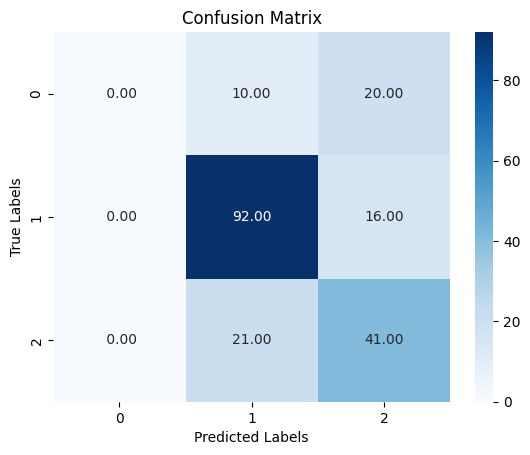

In [51]:
sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tf_keras.preprocessing.text import Tokenizer
from tf_keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM, Flatten
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [53]:
df = pd.read_csv("archive/data.csv")
df

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
...,...,...
5837,RISING costs have forced packaging producer Hu...,negative
5838,Nordic Walking was first used as a summer trai...,neutral
5839,"According shipping company Viking Line , the E...",neutral
5840,"In the building and home improvement trade , s...",neutral


<Axes: xlabel='Sentiment'>

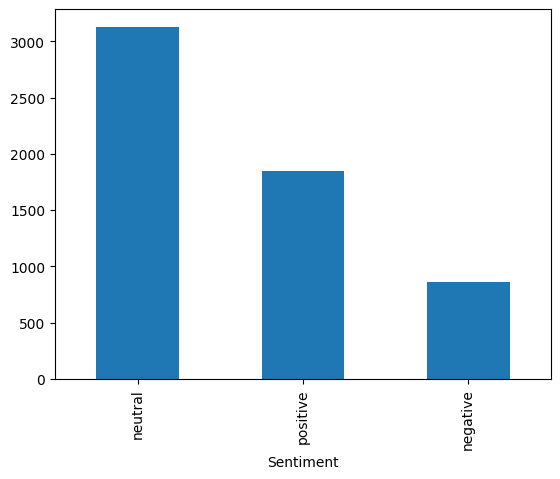

In [54]:
df["Sentiment"].value_counts().plot.bar()

In [55]:
df.isnull().sum()

Sentence     0
Sentiment    0
dtype: int64

<Axes: ylabel='Frequency'>

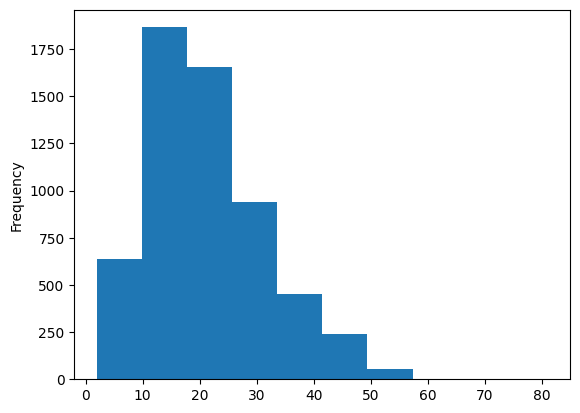

In [56]:
df["Sentence"].str.split(" ").apply(len).plot.hist()

<Axes: >

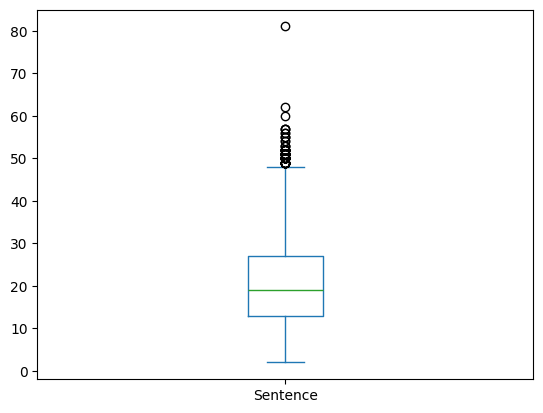

In [57]:
df["Sentence"].str.split().apply(len).plot.box()

In [59]:
df = df[df["Sentence"].str.split().apply(len) < 48].copy(deep=True)
df

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
...,...,...
5837,RISING costs have forced packaging producer Hu...,negative
5838,Nordic Walking was first used as a summer trai...,neutral
5839,"According shipping company Viking Line , the E...",neutral
5840,"In the building and home improvement trade , s...",neutral


<Axes: ylabel='Frequency'>

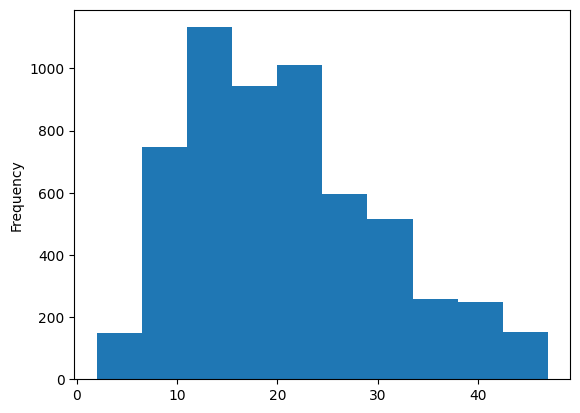

In [60]:

df["Sentence"].str.split().apply(len).plot.hist()

<Axes: >

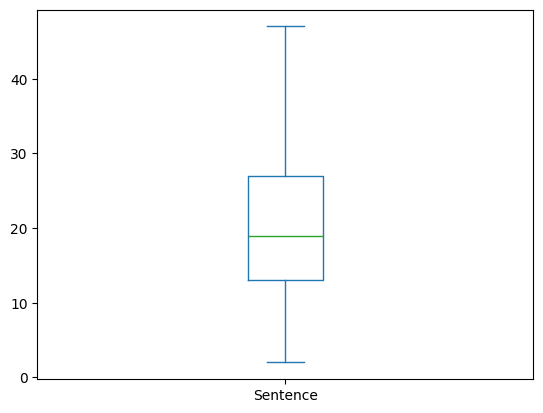

In [61]:
df["Sentence"].str.split().apply(len).plot.box()

In [62]:
def get_vocabulary(texts: list[str]) -> list[str]:
    vocabulary = []
    for text in texts:
        for word in text.split(" "):
            vocabulary.append(word)
    return list(set(vocabulary))

In [63]:
vocabulary = get_vocabulary(df["Sentence"].tolist())

In [64]:
len(vocabulary)

15444

In [65]:
max_vocabulary_size = 14000

In [66]:
X, y = df["Sentence"], pd.get_dummies(df["Sentiment"])

In [67]:
y.head()

,negative,neutral,positive
0,False,False,True
1,True,False,False
2,False,False,True
3,False,True,False
4,False,True,False


In [68]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

In [69]:
tokenizer = Tokenizer(num_words=max_vocabulary_size)
tokenizer.fit_on_texts(train_X.values)
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

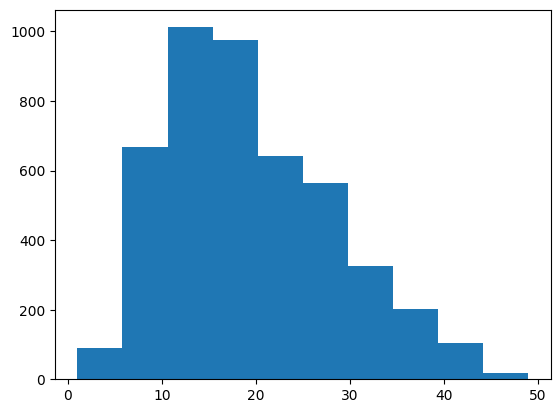

In [70]:
plt.hist([len(tokens) for tokens in train_X]);

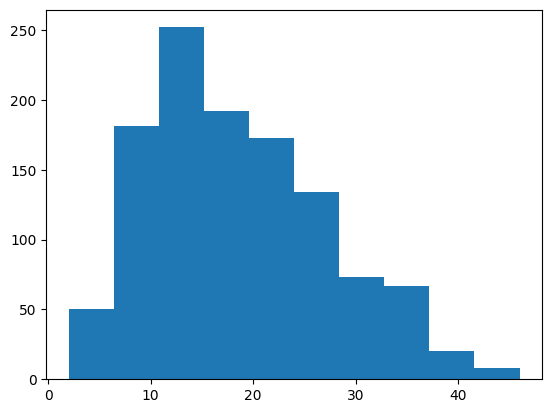

In [72]:
plt.hist([len(tokens) for tokens in test_X]);

In [73]:
maxlen = 30

In [74]:
train_X = sequence.pad_sequences(train_X, maxlen=maxlen)
test_X = sequence.pad_sequences(test_X, maxlen=maxlen)

In [75]:
train_X.shape, test_X.shape

((4600, 30), (1150, 30))

In [77]:
model = Sequential([
    Embedding(input_dim=max_vocabulary_size, output_dim=32),
    Conv1D(filters=32, kernel_size=4, padding="same", activation="relu"),
    MaxPooling1D(pool_size=2),
    LSTM(64, dropout=0.1, recurrent_dropout=0.1),
    Dense(3, activation="softmax")
])

In [78]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["precision", "recall", "f1_score"]
)

In [79]:
history = model.fit(train_X, train_y, validation_split=0.2, batch_size=64, epochs=8)

Epoch 1/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - f1_score: 0.2598 - loss: 1.0227 - precision: 0.4436 - recall: 0.1919 - val_f1_score: 0.2335 - val_loss: 0.9146 - val_precision: 0.6427 - val_recall: 0.4478
Epoch 2/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - f1_score: 0.3259 - loss: 0.8695 - precision: 0.7056 - recall: 0.4468 - val_f1_score: 0.4394 - val_loss: 0.8557 - val_precision: 0.6872 - val_recall: 0.5087
Epoch 3/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - f1_score: 0.5054 - loss: 0.6395 - precision: 0.8017 - recall: 0.6408 - val_f1_score: 0.4844 - val_loss: 0.8456 - val_precision: 0.7383 - val_recall: 0.6196
Epoch 4/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - f1_score: 0.6761 - loss: 0.4102 - precision: 0.8849 - recall: 0.7523 - val_f1_score: 0.5903 - val_loss: 0.9161 - val_precision: 0.7284 - val_recall: 0.6152
Epoch 5/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - f1_score: 0.8471 - loss: 0.2681 - precision: 0.9165 - recall: 0.8545 - val_f1_score: 0.5924 - val_loss: 1.0940 - va

In [80]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 30, 32)              │         448,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 30, 32)              │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 15, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,431,467 (5.46 MB)

 Trainable params: 477,155 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 954,312 (3.64 MB)

<Axes: >

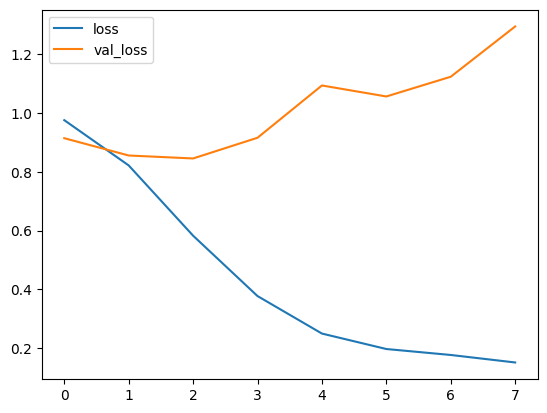

In [81]:
sns.lineplot(history.history["loss"], label="loss")
sns.lineplot(history.history["val_loss"], label="val_loss")